<h1>Importando bibliotecas</h1>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from IPython.display import clear_output
import tensorflow as tf
import os
import _pickle as cPickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
tf.get_logger().setLevel('ERROR')
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #Por algum motivo o CUDA parou de funcionar pra mim ;-;


<h1>Parâmetros e funções auxiliares</h1>

In [2]:
dataset = 'Arface_mtcnn_v2/'
faces = dataset + 'face/'
qtdeHomens = 76 #76
qtdeMulheres = 60 #60
qtdePoses = 13 #13
qtdeSessoes = 2

In [3]:
def corrigirLimite(x, limS):
    if x < 0:
        return 0
    if x > limS:
        return limS
    return x

detector = MTCNN()

#Extraindo face usando MTCNN
def extract_face(filename, required_size=(224, 224)):
    try:
        pixels = plt.imread(filename)
        h = pixels.shape[0]
        w = pixels.shape[1]
        results = detector.detect_faces(pixels)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height

        x1 = corrigirLimite(x1, w)
        x2 = corrigirLimite(x2, w)
        y1 = corrigirLimite(y1, h)
        y2 = corrigirLimite(y2, h)

        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = asarray(image)
        return face_array
    except:
         return asarray(Image.new('RGB', (224, 224)))

#Extraindo região ocular usando MTCNN
def extract_eye(filename, s = 'left', required_size=(224, 224)):
    try:
        pixels = plt.imread(filename)
        h = pixels.shape[0]
        w = pixels.shape[1]
        detector = MTCNN()
        results = detector.detect_faces(pixels)
        x, y, width, height = results[0]['box']

        xMouthR, yMouthR = results[0]['keypoints']['mouth_right']
        xMouthL, yMouthL = results[0]['keypoints']['mouth_left']
        yMouthM = (yMouthR + yMouthL)//2
        xMouthM = (xMouthR + xMouthL)//2
        xEyeR, yEyeR = results[0]['keypoints']['right_eye']
        xEyeL, yEyeL = results[0]['keypoints']['left_eye']
        xEyeM = (xEyeR + xEyeL)//2
        yEyeM = (yEyeR + yEyeL)//2
        hEye = np.abs(yMouthM - yEyeM)//3

        x1 = x2 = y1 = y2 = 0
        if s == 'left':
            y1 = yEyeL - hEye
            y2 = yEyeL + hEye
            x1 = x
            x2 = xEyeM
        else:
            y1 = yEyeR - hEye
            y2 = yEyeR + hEye
            x1 = xEyeM
            x2 = x + width

        print(x1, x2, y1, y2)

        x1 = corrigirLimite(x1, w)
        x2 = corrigirLimite(x2, w)
        y1 = corrigirLimite(y1, h)
        y2 = corrigirLimite(y2, h)

        print(x1, x2, y1, y2)

        eye = pixels[y1:y2, x1:x2]
        image = Image.fromarray(eye)
        image = image.resize(required_size)
        eye_array = asarray(image)
        return eye_array
    except:
         return asarray(Image.new('RGB', (224, 224)))

In [4]:
def getPath(genero, idPessoa, pose = 1, sessao = 0):
    pref = 'Cm'
    if genero == 'F':
        pref = 'Cw'
    pessoa = '{:03d}'.format(idPessoa)
    pose += sessao*qtdePoses
    filepath = faces + pref + '-' + pessoa + '-' + str(pose) + '_face.bmp'
    return filepath

In [5]:
def abrirFace(genero, idPessoa, pose = 1, sessao = 0):
    filepath = getPath(genero, idPessoa, pose, sessao)
    return extract_face(filepath)

In [6]:
def abrirOlho(genero, idPessoa, lado = 'left', pose = 1, sessao = 0):
    filepath = getPath(genero, idPessoa, pose, sessao)
    return extract_eye(filepath, lado)

<h3>Preparando base de dados</h3>

In [7]:
pessoas = []
filenames = []
qtdeArqs = 0

idP = 0
for h in range(qtdeHomens):
    pessoas.append([])
    for s in range(qtdeSessoes):
        for p in range(qtdePoses):
            filenames.append(getPath('M', h+1, p+1, s))
            pessoas[idP].append(qtdeArqs)
            qtdeArqs += 1
    idP += 1

for m in range(qtdeMulheres):
    pessoas.append([])
    for s in range(qtdeSessoes):
        for p in range(qtdePoses):
            filenames.append(getPath('F', m+1, p+1, s))
            pessoas[idP].append(qtdeArqs)
            qtdeArqs += 1
    idP += 1

<h1>Extração de descritores e funções de autenticação</h1>

In [8]:
#Extração de descritores das faces usando VGGFace
def get_embeddings_faces(filenames):
    print('Iniciando extração')
    facesE = []
    x = 0
    total = (qtdeHomens + qtdeMulheres)*qtdeSessoes*qtdePoses
    print('0/', total, sep='', flush=True)
    for f in filenames:
        facesE.append(extract_face(f))
        clear_output(wait=True)
        x += 1
        print(x, '/', total, sep='', flush=True)
    print('Faces extraidas')
    samples = asarray(facesE, 'float32')
    samples = preprocess_input(samples, version=2)
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    print('Modelo instanciado')
    yhat = model.predict(samples)
    print('Descritores VGGFace extraídos')
    return yhat

#Extração de descritores das regiões oculares usando VGGFace
def get_embeddings_eyes(filenames, lado):
    print('Iniciando extração')
    olhosE = []
    x = 0
    total = (qtdeHomens + qtdeMulheres)*qtdeSessoes*qtdePoses
    print('0/', total, sep='', flush=True)
    for f in filenames:
        olhosE.append(extract_eye(f, lado))
        clear_output(wait=True)
        x += 1
        print(x, '/', total, sep='', flush=True)
    print('Regiões oculares extraidas')
    samples = asarray(olhosE, 'float32')
    samples = preprocess_input(samples, version=2)
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    print('Modelo instanciado')
    yhat = model.predict(samples)
    print('Descritores VGGFace extraídos')
    return yhat


#Determina se o descritor candidato corresponde ao conhecido, utilizando cosine distance, considerando um limiar thresh
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        #print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
        return True
    else:
        #print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
        return False

<h1>Autenticação</h1>

In [56]:
def diferencaAmostras(descritores, posesAceitas):
    yActual = []
    yProb = []
    for p in range(qtdeHomens + qtdeMulheres):
        amostraProva = descritores[pessoas[p][0]] #pose normal
        #amostras verdadeiras/da mesma pessoas
        for s in range(qtdeSessoes):
            for pose in posesAceitas:
                if (pose == 0) and (s == 0):  #não vamos comparar a imagem com si mesma
                    continue;
                yActual.append(1)
                amostraCandidata = descritores[pessoas[p][pose + s*qtdePoses]]
                yProb.append(float(1-cosine(amostraProva, amostraCandidata)))
        #amostras falsas/pessoas diferentes
        for p2 in range(p+1, qtdeHomens + qtdeMulheres):
            for s in range(qtdeSessoes):
                for pose in posesAceitas:
                    yActual.append(0)
                    amostraCandidata = descritores[pessoas[p2][pose + s*qtdePoses]]
                    yProb.append(float(1-cosine(amostraProva, amostraCandidata)))
    return (yActual, yProb)

<h2>Faces neutras - VGGFace</h2>

In [10]:
#descritoresVGG = get_embeddings_faces(filenames) 
with open('descFacesVGG.pkl', 'rb') as fid: #Lendo descritores já extraídos
    descritoresVGG = cPickle.load(fid)

In [11]:
descritoresVGG

array([[2.7485640e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.7324944e+00,
        1.7534347e+00, 2.5124109e-01],
       [9.4908160e-01, 0.0000000e+00, 0.0000000e+00, ..., 4.2591801e+00,
        7.1327871e-01, 3.7103159e+00],
       [1.3749884e+00, 9.3822807e-01, 0.0000000e+00, ..., 6.8258867e+00,
        1.6768528e+00, 4.4632229e-01],
       ...,
       [3.7275679e-02, 0.0000000e+00, 0.0000000e+00, ..., 4.3437034e-01,
        2.1291995e+00, 4.9423604e+00],
       [0.0000000e+00, 3.4130691e-03, 0.0000000e+00, ..., 1.0038435e+00,
        5.1227474e-01, 4.1406283e+00],
       [1.5483378e-01, 1.0486158e-02, 0.0000000e+00, ..., 1.9929326e-01,
        1.1342582e+00, 5.4405541e+00]], dtype=float32)

In [12]:
#with open('descFacesVGG.pkl', 'wb') as fid:
#    cPickle.dump(descritoresVGG, fid) 

In [12]:
yActual, yPred = diferencaAmostras(descritoresVGG, {0})

In [13]:
with open('yFNcos.pkl', 'wb') as fid:
    cPickle.dump(yActual, fid) 
with open('yFNcosPred.pkl', 'wb') as fid:
    cPickle.dump(yPred, fid) 

In [14]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

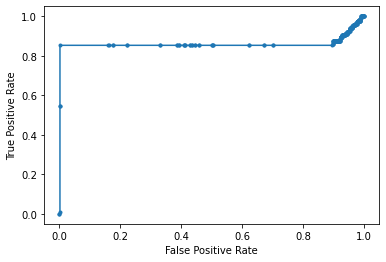

In [15]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [16]:
bestF1 = 0
bestThres = 0
for t in thres:
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

F1-score: 0.8140350877192983
Melhor limiar: 0.7555031776428223


In [17]:
roc_auc_score(yActual, yPred)

0.8591106785851595

<h2>Todas as faces - VGGFace</h2>

In [16]:
yActual, yPred = diferencaAmostras(descritoresVGG, {x for x in range(qtdePoses)})

In [17]:
with open('yTFcos.pkl', 'wb') as fid:
    cPickle.dump(yActual, fid) 
with open('yTFcosPred.pkl', 'wb') as fid:
    cPickle.dump(yPred, fid) 

In [18]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

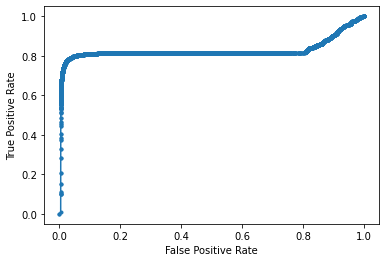

In [19]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [22]:
bestF1 = 0
bestThres = 0
x = 0
for t in np.arange(0, 1, 0.01):
    clear_output(wait=True)
    x += 1
    print(x, '/', len(np.arange(0, 1, 0.01)), sep='', flush=True)
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

100/7051
F1-score: 0.6324165852296524
Melhor limiar: 0.61


In [23]:
roc_auc_score(yActual, yPred)

0.8275421490994588

<h2>Regiões oculares - esquerdo - faces neutras - VGGFace</h2>

In [61]:
#descritoresVGG = get_embeddings_eyes(filenames, 'left')
with open('descOlhosEsqVGG.pkl', 'rb') as fid:
    descritoresVGG = cPickle.load(fid)

In [11]:
descritoresVGG

array([[0.0000000e+00, 3.7595441e+00, 0.0000000e+00, ..., 9.2224684e-04,
        8.1624009e-02, 0.0000000e+00],
       [0.0000000e+00, 5.6846678e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 2.1014856e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 9.1508299e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.2742023e-01, 0.0000000e+00, ..., 0.0000000e+00,
        1.9120066e+00, 0.0000000e+00]], dtype=float32)

In [12]:
#with open('descOlhosEsqVGG.pkl', 'wb') as fid:
#    cPickle.dump(descritoresVGG, fid) 

In [13]:
yActual, yPred = diferencaAmostras(descritoresVGG, {0})

In [14]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

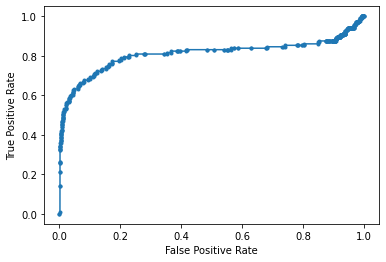

In [15]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [16]:
bestF1 = 0
bestThres = 0
for t in thres:
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

F1-score: 0.4055299539170507
Melhor limiar: 0.8931424021720886


In [17]:
roc_auc_score(yActual, yPred)

0.8100438132769447

<h2>Regiões oculares - esquerda - sem oculos - VGGFace</h2>

In [62]:
yActual, yPred = diferencaAmostras(descritoresVGG, posesAceitas={0, 1, 2, 3, 4, 5, 6, 10, 11, 12})

In [63]:
with open('yOlhoEsq.pkl', 'wb') as fid:
    cPickle.dump(yActual, fid) 
with open('yOlhoEsqPred.pkl', 'wb') as fid:
    cPickle.dump(yPred, fid) 

In [64]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

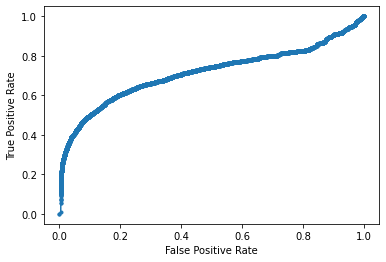

In [65]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [21]:
bestF1 = 0
bestThres = 0
x = 0
for t in np.arange(0, 1, 0.01):
    clear_output(wait=True)
    x += 1
    print(x, '/', len(np.arange(0, 1, 0.01)), sep='', flush=True)
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

100/100
F1-score: 0.26178635369007364
Melhor limiar: 0.84


In [22]:
roc_auc_score(yActual, yPred)

0.7139952877435805

<h2>Regiões oculares - direita - faces neutras - VGGFace</h2>

In [23]:
descritoresVGG = get_embeddings_eyes(filenames, 'right')

3536/3536
Regiões oculares extraidas
Modelo instanciado
Descritores VGGFace extraídos


In [24]:
descritoresVGG

array([[0.00000000e+00, 1.07518172e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.29168129e+00, 0.00000000e+00],
       [0.00000000e+00, 1.85861707e-01, 0.00000000e+00, ...,
        0.00000000e+00, 2.86978600e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.02075655e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.48844640e-02, ...,
        0.00000000e+00, 6.03024244e-01, 0.00000000e+00],
       [0.00000000e+00, 1.87961543e+00, 7.38503188e-02, ...,
        0.00000000e+00, 2.99324465e+00, 0.00000000e+00],
       [0.00000000e+00, 5.04511833e-01, 2.22758114e-01, ...,
        0.00000000e+00, 2.43519163e+00, 0.00000000e+00]], dtype=float32)

In [25]:
with open('descOlhosDirVGG.pkl', 'wb') as fid:
    cPickle.dump(descritoresVGG, fid) 

In [66]:
with open('descOlhosDirVGG.pkl', 'rb') as fid:
    descritoresVGG = cPickle.load(fid)

In [67]:
yActual, yPred = diferencaAmostras(descritoresVGG, {0})

In [27]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

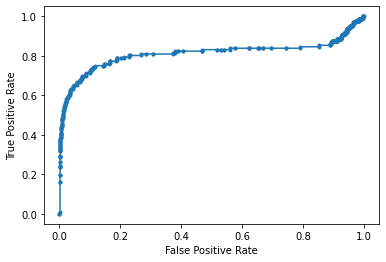

In [28]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [29]:
bestF1 = 0
bestThres = 0
for t in thres:
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

F1-score: 0.41134751773049644
Melhor limiar: 0.8656359314918518


In [30]:
roc_auc_score(yActual, yPred)

0.8108433855568371

<h2>Regiões oculares - direita - sem oculos - VGGFace</h2>

In [69]:
yActual, yPred = diferencaAmostras(descritoresVGG, {0, 1, 2, 3, 4, 5, 6, 10, 11, 12})

In [70]:
with open('yOlhoDir.pkl', 'wb') as fid:
    cPickle.dump(yActual, fid) 
with open('yOlhoDirPred.pkl', 'wb') as fid:
    cPickle.dump(yPred, fid) 

In [71]:
fpr, tpr, thres = roc_curve(yActual, yPred)

Text(0, 0.5, 'True Positive Rate')

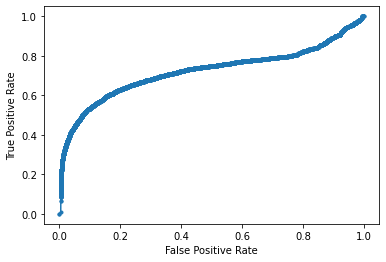

In [72]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [35]:
bestF1 = 0
bestThres = 0
x = 0
for t in np.arange(0, 1, 0.01):
    clear_output(wait=True)
    x += 1
    print(x, '/', len(np.arange(0, 1, 0.01)), sep='', flush=True)
    yPredT = [1 if x >= t else 0 for x in yPred]
    f1s = f1_score(yActual, yPredT)
    if f1s > bestF1:
        bestF1 = f1s
        bestThres = t
print('F1-score:', bestF1)
print('Melhor limiar:', bestThres)

100/100
F1-score: 0.27431513145798864
Melhor limiar: 0.8300000000000001


In [36]:
roc_auc_score(yActual, yPred)

0.7223205143770615

<h1>Classificadores para autenticação</h1>

In [20]:
import pandas as pd
import numpy as np
import sys
import sklearn
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn import svm
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from random import choice, sample, shuffle
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import _pickle as cPickle
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [21]:
def treinarModelo(model, hyper, X, Y):  
    metricas = ['f1', 'accuracy', 'precision', 'recall', 'auc']
    search = RandomizedSearchCV(estimator = model, param_distributions =hyper, scoring=metricas, verbose=3, refit='f1', n_iter=50, cv = 3, return_train_score=False, n_jobs=2)
    search.fit(X, Y);
    model = search.best_estimator_
    print('Melhor f1-score:', search.best_score_)
    print('Melhores parâmetros:', search.best_params_)
    return model

In [22]:
def testarModelo(Y, Y_test):
    print('Matriz de confusão')
    print('')
    print(pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted']))
    print('')
    print('Métricas I')
    accuracy = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average="binary")
    precision = precision_score(Y_test, Y_pred, average="binary")
    f1 = f1_score(Y_test, Y_pred, average="binary")
    print("accuracy")
    print("%.6f" %accuracy)
    print("racall")
    print("%.6f" %recall)
    print("precision")
    print("%.6f" %precision)
    print("f1score")
    print("%.6f" %f1)

In [23]:
#Função para calcular a diferença de dois descritores
def subtract(a, b):
    c = []
    for i in range(len(a)):
        c.append(a[i]-b[i])
    return c

def diferencaAmostras(descritores, pessoasAceitas, posesAceitas):
    yActual = []
    difAmost = []
    for i in range(len(pessoasAceitas)):
        p = pessoasAceitas[i]
        amostraProva = descritores[pessoas[p][0]] #pose normal
        #amostras verdadeiras/da mesma pessoas
        for s in range(qtdeSessoes):
            for pose in posesAceitas:
                if (pose == 0) and (s == 0):  #não vamos comparar a imagem com si mesma
                    continue;
                yActual.append(1)
                amostraCandidata = descritores[pessoas[p][pose + s*qtdePoses]]
                difAmost.append(subtract(amostraProva, amostraCandidata))
        #amostras falsas/pessoas diferentes
        for j in range(i+1, len(pessoasAceitas)):
            p2 = pessoasAceitas[j]
            for s in range(qtdeSessoes):
                for pose in posesAceitas:
                    yActual.append(0)
                    amostraCandidata = descritores[pessoas[p2][pose + s*qtdePoses]]
                    difAmost.append(subtract(amostraProva, amostraCandidata))
    return (yActual, difAmost)

In [24]:
#Separando conjunto de treino e teste
pessoasInd = [x for x in range(qtdeHomens + qtdeMulheres)]
shuffle(pessoasInd)

In [26]:
train = pessoasInd[:int(0.6*len(pessoasInd))]
test = pessoasInd[int(0.6*len(pessoasInd)):]
with open('trainClass.pkl', 'wb') as fid:
    cPickle.dump(train, fid) 
with open('testClass.pkl', 'wb') as fid:
    cPickle.dump(test, fid) 

In [10]:
with open('descFacesVGG.pkl', 'rb') as fid:
    descritoresVGG = cPickle.load(fid)

<h2>Faces Neutras</h2>

In [33]:
yActualTrain, difTrain = diferencaAmostras(descritoresVGG, train, {0})

In [34]:
len(yActualTrain)

6561

In [35]:
model = svm.SVC(probability=True, verbose=1)
model.fit(difTrain, yActualTrain)
with open('SVMneutral.pkl', 'wb') as fid:
    cPickle.dump(model, fid) 

[LibSVM]

In [27]:
with open('SVMneutral.pkl', 'rb') as fid:
    model = cPickle.load(fid)

In [36]:
yActualTest, difTest = diferencaAmostras(descritoresVGG, test, {0})

In [37]:
Y_prob = model.predict_proba(difTest)

In [38]:
Y_pred = []
for x in Y_prob:
    Y_pred.append(x[1])

In [41]:
with open('yFNsvm.pkl', 'wb') as fid:
    cPickle.dump(yActualTest, fid) 
with open('yFNsvmPred.pkl', 'wb') as fid:
    cPickle.dump(Y_pred, fid) 

In [39]:
fpr, tpr, thres = roc_curve(yActualTest, Y_pred)

Text(0, 0.5, 'True Positive Rate')

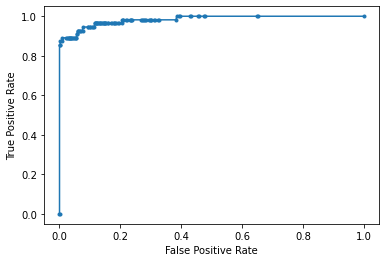

In [40]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

<h2>Todas as faces</h2>

In [42]:
yActualTrain, difTrain = diferencaAmostras(descritoresVGG, train, {x for x in range(qtdePoses)})

In [43]:
len(yActualTrain)

86265

In [44]:
scaler = StandardScaler()
difTrainNorm = scaler.fit_transform(difTrain)

In [45]:
with open('scalerAll.pkl', 'wb') as fid:
    cPickle.dump(scaler, fid) 

In [46]:
model = svm.SVC(probability=True, verbose=1, max_iter=5000)
model.fit(difTrainNorm, yActualTrain)
with open('SVMall.pkl', 'wb') as fid:
    cPickle.dump(model, fid) 

[LibSVM]

c:\users\pedro\miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [47]:
yActualTest, difTest = diferencaAmostras(descritoresVGG, test, {x for x in range(qtdePoses)})

In [48]:
difTestNorm = scaler.transform(difTest)

In [49]:
Y_prob = model.predict_proba(difTestNorm)

In [50]:
Y_pred = []
for x in Y_prob:
    Y_pred.append(x[1])

In [51]:
with open('yTFsvm.pkl', 'wb') as fid:
    cPickle.dump(yActualTest, fid) 
with open('yTFsvmPred.pkl', 'wb') as fid:
    cPickle.dump(Y_pred, fid) 

In [52]:
fpr, tpr, thres = roc_curve(yActualTest, Y_pred)

Text(0, 0.5, 'True Positive Rate')

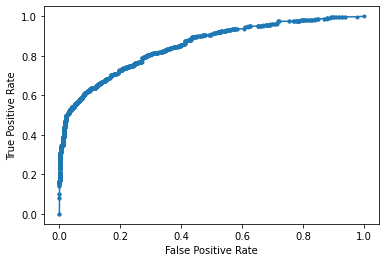

In [53]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')